# Julia Deep Learning

https://fluxml.ai/

https://github.com/FluxML/model-zoo

In [1]:
using Flux
using CuArrays
using Plots
using Plots.PlotMeasures

CuArrays.allowscalar(false)

pyplot()

┌ Warning: Incompatibility detected between CUDA and LLVM 8.0+; disabling debug info emission for CUDA kernels
└ @ CUDAnative /home/cavani/Workspace/julia-abc/software/julia-env/packages/CUDAnative/hfulr/src/CUDAnative.jl:114


Plots.PyPlotBackend()

## MNIST Dataset

In [2]:
function load_mnist(split_name)
    mnist = Flux.Data.MNIST
    
    images = mnist.images(split_name) # Array with N images of 28x28 8-bits gray
    labels = mnist.labels(split_name) # Array with N labels scalar 0-9
    
    return (images=images, labels=labels)
end

train_data = load_mnist(:train)
test_data = load_mnist(:test)

println("Train images:\n",
        "\ntype = ", typeof(train_data.images),
        "\nsize = ", size(train_data.images),
        "\nshape = ", size(train_data.images[1]),
        "\n")
println("Train labels:\n",
        "\ntype = ", typeof(train_data.labels),
        "\nsize = ", size(train_data.labels),
        "\n")
println("Test images:\n",
        "\ntype = ", typeof(test_data.images),
        "\nsize = ", size(test_data.images),
        "\nshape = ", size(test_data.images[1]),
        "\n")
println("Test labels:\n",
        "\ntype = ", typeof(test_data.labels),
        "\nsize = ", size(test_data.labels))

Train images:

type = Array{Array{Gray{FixedPointNumbers.Normed{UInt8,8}},2},1}
size = (60000,)
shape = (28, 28)

Train labels:

type = Array{Int64,1}
size = (60000,)

Test images:

type = Array{Array{Gray{FixedPointNumbers.Normed{UInt8,8}},2},1}
size = (10000,)
shape = (28, 28)

Test labels:

type = Array{Int64,1}
size = (10000,)


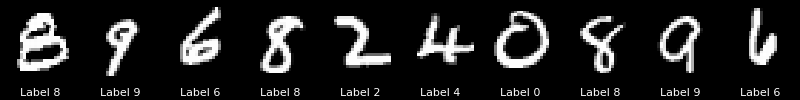

In [3]:
plot_digit(image, label) = plot(image, xlabel=(label !== nothing ? "Label $(label)" : ""),
                                guidefontsize=8, legend=false, margin=0mm, link=:both,
                                ticks=nothing, border=:none)
function plot_digits(images, labels=nothing; size=(800, 100), layout=(1, length(images)))
    plots = map(1:prod(layout)) do i
        image = images[i]
        label = labels !== nothing ? labels[i] : nothing
        plot_digit(image, label)
    end
    plot(plots..., layout=layout, size=size, bg_color="black", fg_color="white")
end

function sample(data, size=10)
    indices = rand(1:length(data.images), 10)
    images = data.images[indices]
    labels = data.labels[indices]
    return (images=images, labels=labels)
end

train_sample = sample(train_data)
plot_digits(train_sample...)

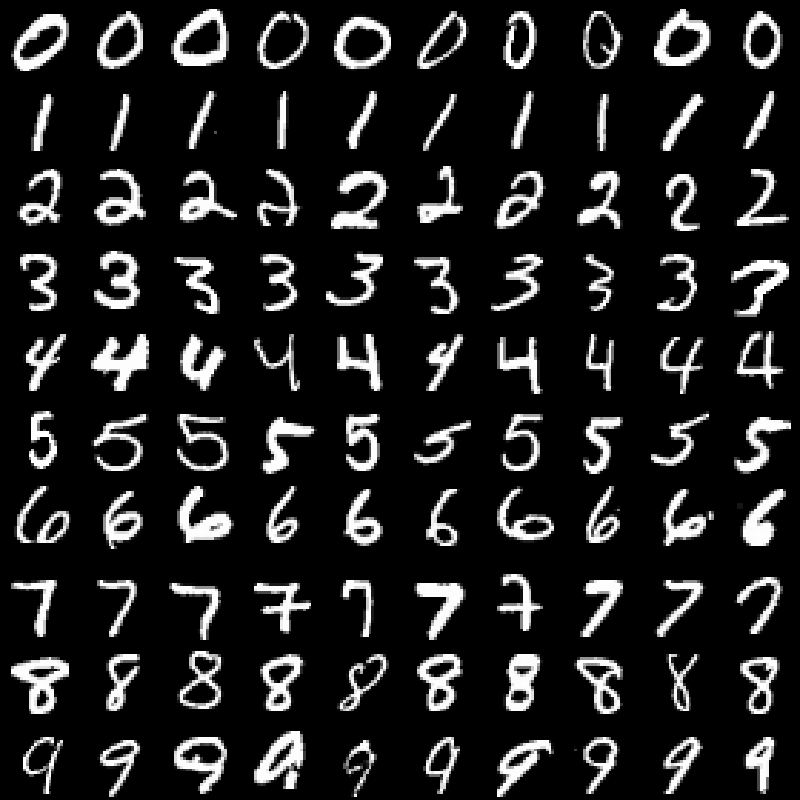

In [4]:
function sample_classes(data, sample_size_per_class=10)
    class_vector = sort(unique(data.labels))
    samples = map(class_vector) do label
        label_indices = findall(==(label), data.labels)
        sample_indices = rand(label_indices, sample_size_per_class)
        images = data.images[sample_indices]
        images
    end
    return samples
end

train_sample2 = sample_classes(train_data)
plot_digits(vcat(train_sample2...); size=(800, 800), layout=(10, 10))

In [5]:
function compute_num_channels(image)
    color_type = eltype(image)
    if color_type <: Gray
        return 1
    elseif color_type <: RGB
        return 3
    else
        error("Unknown color type: $(color_type)")
    end
end

function make_whcn_format(images)
    width, height = size(images[1])
    num_channels = compute_num_channels(images[1])
    batch_size = length(images)
    @assert num_channels == 1 # only Gray -> Foloat32 supported

    images_tensor = Array{Float32, 4}(undef, width, height, num_channels, batch_size)
    for (batch_index, image) in enumerate(images)
        images_tensor[:, :, :, batch_index] = Float32.(reshape(image, width, height, num_channels))
    end
    return images_tensor
end

X_whcn = make_whcn_format(train_sample.images)
println("X (WHCN format):\n",
        "\ntype = ", typeof(X_whcn),
        "\nsize = ", size(X_whcn))

X (WHCN format):

type = Array{Float32,4}
size = (28, 28, 1, 10)


In [6]:
import Flux: onehot

function make_onehot_format(labels, class_vector)
    num_labels = length(class_vector)
    batch_size = length(labels)
    
    labels_tensor = Array{Float32, 2}(undef, num_labels, batch_size)
    for (batch_index, label) in enumerate(labels)
        labels_tensor[:, batch_index] = Float32.(onehot(label, class_vector))
    end
    return labels_tensor
end

y_onehot = make_onehot_format(train_sample.labels, 0:9)
println("y (One Hot format):\n",
        "\ntype = ", typeof(y_onehot),
        "\nsize = ", size(y_onehot))

y (One Hot format):

type = Array{Float32,2}
size = (10, 10)


In [7]:
import Base.Iterators: partition

function make_batch(images, labels)
    X = make_whcn_format(images)
    y = make_onehot_format(labels, 0:9)
    return (X=X, y=y)
end

function make_dataset(images, labels; batch_size)
    batch_size == 0 && return make_batch(images, labels)
    
    num_examples = length(images)
    num_batches = ceil(Int, num_examples / batch_size)
    batch_indices = partition(1:num_examples, batch_size)
    batches = map(batch_indices) do indices
        make_batch(images[indices], labels[indices])
    end
    return batches
end

dataset_train = make_dataset(train_data...; batch_size=256)
dataset_test = make_dataset(test_data...; batch_size=0)

println("Train\n")
println("Number of batches   : ", length(dataset_train))
println("First batch X shape : ", size(dataset_train[1].X))
println("First batch y shape : ", size(dataset_train[1].y))
println("Last batch X shape  : ", size(dataset_train[end].X))
println("Last batch y shape  : ", size(dataset_train[end].y))
println()
println("Test\n")
println("X shape             : ", size(dataset_test.X))
println("y shape             : ", size(dataset_test.y))

Train

Number of batches   : 235
First batch X shape : (28, 28, 1, 256)
First batch y shape : (10, 256)
Last batch X shape  : (28, 28, 1, 96)
Last batch y shape  : (10, 96)

Test

X shape             : (28, 28, 1, 10000)
y shape             : (10, 10000)


## More API

In [8]:
flatten(x) = reshape(x, :, size(x)[end])

struct Reshape
    dims
end

(layer::Reshape)(x) = reshape(x, layer.dims..., size(x)[end])

In [9]:
import Flux: train!
import BSON: bson, load
import Printf: @printf

bind_model(f, model) = (args...) -> f(model, args...)

function run_train(model, train_data, eval_data;
                   loss, metric,
                   optimizer=ADAM(0.001),
                   num_epochs=100,
                   early_stopping_mode=:max,
                   early_stopping_target=nothing,
                   early_stopping_patience=10,
                   learning_rate_schedule=5,
                   model_file="model.bson")
    if early_stopping_mode == :max
        better_metric = ≥
    elseif early_stopping_mode == :min
        better_metric = ≤
    else
        error("early_stopping_mode unknown: $early_stopping_mode")
    end
    compute_loss = bind_model(loss, model)
    compute_metric = bind_model(metric.fn, model)
    best_metric = nothing
    last_improvement = 0

    epoch_train_loss = Float32[]
    epoch_train_metric = Float32[]
    epoch_eval_loss = Float32[]
    epoch_eval_metric = Float32[]
    
    for epoch_idx in 1:num_epochs
        train_loss_avg = 0.0f0
        train_metric_avg = 0.0f0
        # Train for a single epoch
        for i in 1:length(train_data)
            let data = gpu(train_data[i])
                train!(compute_loss, params(model), [data], optimizer)
                train_loss_avg += (compute_loss(data...) - train_loss_avg) / i
                train_metric_avg += (compute_metric(data...) - train_metric_avg) / i
            end
        end

        # Calculate metric:
        eval_loss, eval_metric = let data = gpu(eval_data)
            compute_loss(data...), compute_metric(data...)
        end

        push!(epoch_train_loss, train_loss_avg)
        push!(epoch_train_metric, train_metric_avg)
        push!(epoch_eval_loss, eval_loss)
        push!(epoch_eval_metric, eval_metric)
        
        @printf("[%d] Eval %s: %.4f\n", epoch_idx, metric.name, eval_metric)

        # If this is the best metric we've seen so far, save the model out
        if best_metric === nothing || better_metric(eval_metric, best_metric)
            println(" -> New best $(metric.name)! Saving model out to $(model_file)")
            bson(model_file,
                model  = cpu(model),
                epoch  = epoch_idx,
                metric = eval_metric
            )
            best_metric = eval_metric
            last_improvement = epoch_idx
        end

        # If our metric is good enough, quit out.
        if early_stopping_target !== nothing && better_metric(eval_metric, early_stopping_target)
            println(" -> Early-exiting: We reached our target $(metric.name) of $early_stopping_target")
            break
        end

        # If we haven't seen improvement in N epochs, drop our learning rate:
        if epoch_idx - last_improvement ≥ learning_rate_schedule && optimizer.eta > 1e-6
            optimizer.eta /= 10.0
            println(" -> Haven't improved in a while, dropping learning rate to $(optimizer.eta)!")

            # After dropping learning rate, give it a few epochs to improve
            last_improvement = epoch_idx
        end

        if epoch_idx - last_improvement ≥ early_stopping_patience
            println(" -> We're calling this converged.")
            break
        end
    end
    
    return (
        metric_name        = metric.name,
        epoch_train_loss   = epoch_train_loss,
        epoch_train_metric = epoch_train_metric,
        epoch_eval_loss    = epoch_eval_loss,
        epoch_eval_metric  = epoch_eval_metric,
    )
end

function load_model(model_file; use_gpu=true)
    model = load(model_file)[:model]
    if use_gpu
        model = gpu(model)
    end
    return model
end

function evaluate(model, eval_data; metrics)
    println("Evaluation\n")
    
    data = gpu(eval_data)
    for metric in metrics
        compute_metric = bind_model(metric.fn, model)
        metric_eval = compute_metric(data...)
        println(rpad(metric.name, 10), " : ", metric_eval)
    end
end

evaluate (generic function with 1 method)

In [10]:
function plot_loss(log; fig_size=(800, 400))
    num_epochs = length(log.epoch_train_loss)
    p = plot(; title="Epoch Loss", xlabel="Epoch", xlims=(0, num_epochs), xticks=0:num_epochs,
               xrotation=90, xtickfontsize=5, ylabel="Loss", framestyle=:semi, size=fig_size)
    plot!(p, log.epoch_train_loss; label="Train")
    plot!(p, log.epoch_eval_loss; label="Eval")
    return p
end

function plot_metric(log; fig_size=(800, 400))
    num_epochs = length(log.epoch_train_metric)
    p = plot(; title="Epoch $(log.metric_name)",
               xlabel="Epoch", xlims=(0, num_epochs), xticks=0:num_epochs,
               xrotation=90, xtickfontsize=5, ylabel=log.metric_name,
               framestyle=:semi, size=fig_size)
    plot!(p, log.epoch_train_metric; label="Train")
    plot!(p, log.epoch_eval_metric; label="Eval")
    return p
end

function plot_train_log(log; fig_size=(1200, 350))
    p_loss = plot_loss(log)
    p_metric = plot_metric(log)
    plot(p_loss, p_metric; layout=(1, 2), size=fig_size)
end

plot_train_log (generic function with 1 method)

In [11]:
import Flux: logitcrossentropy, mse, onecold
import Statistics: mean

function crossentropy(model, x, y)
    logits = model[1:end-1](x)
    return logitcrossentropy(logits, y)
end

function crossentropy_noise(model, x, y)
    x_aug = x .+ 0.1f0 * gpu(randn(eltype(x), size(x)))
    logits = model[1:end-1](x)
    return logitcrossentropy(logits, y)
end

function mse(model, x, y)
    ŷ = model(x)
    return mse(ŷ, y)
end

function accuracy(model, x, y)
    ŷ = model(x)
    return mean(onecold(cpu(ŷ)) .== onecold(cpu(y)))
end

accuracy (generic function with 1 method)

## CNN

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl

In [12]:
function make_cnn(input_shape, output_size; use_gpu=true)
    fc_size = (input_shape.width ÷ 2 ÷ 2 ÷ 2) * (input_shape.height ÷ 2 ÷ 2 ÷ 2) * 32

    model = Chain(
        Conv((3, 3), input_shape.num_channels => 16, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 16 => 32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 32 => 32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        flatten,
        Dense(fc_size, output_size),
        softmax
    )

    if use_gpu
        model = gpu(model)
    end
    
    return model
end

cnn_input_shape = (width=28, height=28, num_channels=1)
cnn_output_size = 10 # 0-9

cnn = make_cnn(cnn_input_shape, cnn_output_size)

Chain(Conv((3, 3), 1=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), flatten, Dense(288, 10), softmax)

In [13]:
X1, y1 = gpu(dataset_train[1])
ŷ1 = cnn(X1)

10×256 CuArray{Float32,2,Nothing}:
 0.106027   0.109194   0.105624   …  0.101774   0.104281   0.104623
 0.0860874  0.0848391  0.0924384     0.0856652  0.0871659  0.0844299
 0.0995795  0.102366   0.0938857     0.10037    0.0997504  0.0977106
 0.100808   0.101715   0.0995766     0.107806   0.0966349  0.100296
 0.110268   0.106878   0.110831      0.115563   0.114373   0.111519
 0.102702   0.100636   0.099183   …  0.0986522  0.0998884  0.10111
 0.0949962  0.0994629  0.0957265     0.0883231  0.101967   0.0974411
 0.0983481  0.100439   0.0954931     0.095164   0.098423   0.100356
 0.0944679  0.0887598  0.0977566     0.0975486  0.0895508  0.0954257
 0.106716   0.105711   0.109485      0.109134   0.107966   0.107089

In [14]:
loss_train = crossentropy_noise(cnn, X1, y1)
metric_train = accuracy(cnn, X1, y1)

println("Train (batch 1)\n")    
println("Loss     : ", loss_train)
println("Accuracy : ", metric_train)

Train (batch 1)

Loss     : 2.303612
Accuracy : 0.10546875


In [15]:
log = run_train(cnn, dataset_train, dataset_test;
                loss=crossentropy_noise,
                metric=(name="Accuracy", fn=accuracy),
                model_file="cnn_mnist.bson");

[1] Eval Accuracy: 0.9504
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[2] Eval Accuracy: 0.9704
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[3] Eval Accuracy: 0.9755
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[4] Eval Accuracy: 0.9799
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[5] Eval Accuracy: 0.9810
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[6] Eval Accuracy: 0.9821
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[7] Eval Accuracy: 0.9831
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[8] Eval Accuracy: 0.9840
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[9] Eval Accuracy: 0.9846
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[10] Eval Accuracy: 0.9848
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[11] Eval Accuracy: 0.9854
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[12] Eval Accuracy: 0.9857
 -> New best Accuracy! Saving model out to cnn_

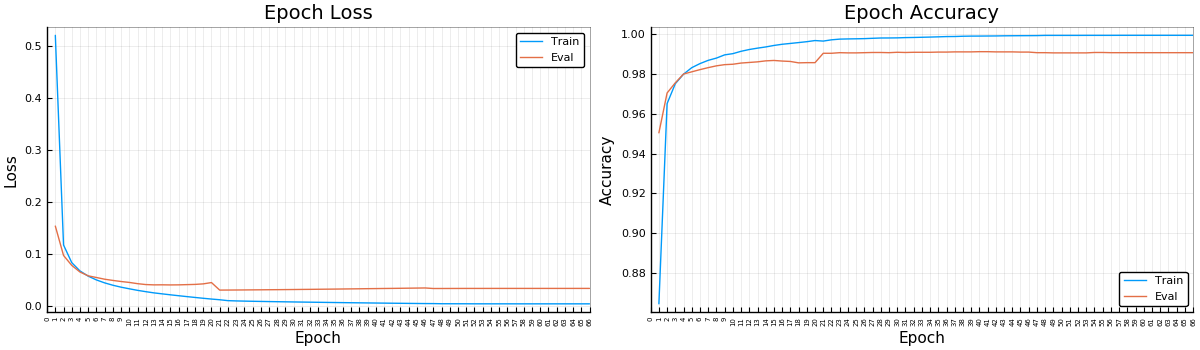

In [16]:
plot_train_log(log)

In [17]:
best_cnn = load_model("cnn_mnist.bson")
evaluate(best_cnn, dataset_test;
         metrics=[(name="Loss", fn=crossentropy_noise), (name="Accuracy", fn=accuracy)])

Evaluation

Loss       : 0.033667997
Accuracy   : 0.9911


In [18]:
best_cnn = nothing
cnn = nothing
X1 = nothing
y1 = nothing
ŷ1 = nothing
GC.gc()

## MLP

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/mlp.jl

In [19]:
function make_mlp(input_size, output_size, hidden_size; use_gpu=true)
    model = Chain(
        flatten,
        Dense(input_size, hidden_size, relu),
        Dense(hidden_size, output_size),
        softmax
    )
    if use_gpu
        model = gpu(model)
    end
    return model
end

mlp_input_size = 28 * 28 * 1 # w * h * #c
mlp_output_size = 10 # 0-9
mlp_hidden_size = 500

mlp = make_mlp(mlp_input_size, mlp_output_size, mlp_hidden_size)

Chain(flatten, Dense(784, 500, relu), Dense(500, 10), softmax)

In [20]:
X1, y1 = gpu(dataset_train[1])
ŷ1 = mlp(X1)

10×256 CuArray{Float32,2,Nothing}:
 0.0990894  0.104886   0.0848008  …  0.0812579  0.110286   0.103854
 0.0721532  0.0956504  0.080812      0.0764501  0.0813032  0.0740671
 0.120756   0.107783   0.118661      0.130714   0.0973768  0.106867
 0.0901349  0.0577495  0.0892127     0.0923822  0.0782266  0.0600356
 0.125018   0.102042   0.15319       0.17375    0.0870664  0.180941
 0.137373   0.0877757  0.107645   …  0.0822332  0.162327   0.114316
 0.13354    0.139287   0.108263      0.135991   0.0934332  0.101185
 0.104528   0.176408   0.0709608     0.123069   0.13388    0.156716
 0.0557082  0.0455874  0.0785594     0.0574356  0.0578464  0.0546465
 0.0616991  0.0828314  0.107896      0.0467174  0.0982553  0.0473715

In [21]:
loss_train = crossentropy(mlp, X1, y1)
metric_train = accuracy(mlp, X1, y1)

println("Train (batch 1)\n")    
println("Loss     : ", loss_train)
println("Accuracy : ", metric_train)

Train (batch 1)

Loss     : 2.4113116
Accuracy : 0.0703125


In [22]:
log = run_train(mlp, dataset_train, dataset_test;
                loss=crossentropy,
                metric=(name="Accuracy", fn=accuracy),
                model_file="mlp_mnist.bson");

[1] Eval Accuracy: 0.9508
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[2] Eval Accuracy: 0.9637
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[3] Eval Accuracy: 0.9698
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[4] Eval Accuracy: 0.9724
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[5] Eval Accuracy: 0.9741
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[6] Eval Accuracy: 0.9747
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[7] Eval Accuracy: 0.9758
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[8] Eval Accuracy: 0.9763
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[9] Eval Accuracy: 0.9769
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[10] Eval Accuracy: 0.9770
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[11] Eval Accuracy: 0.9775
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[12] Eval Accuracy: 0.9782
 -> New best Accuracy! Saving model out to mlp_

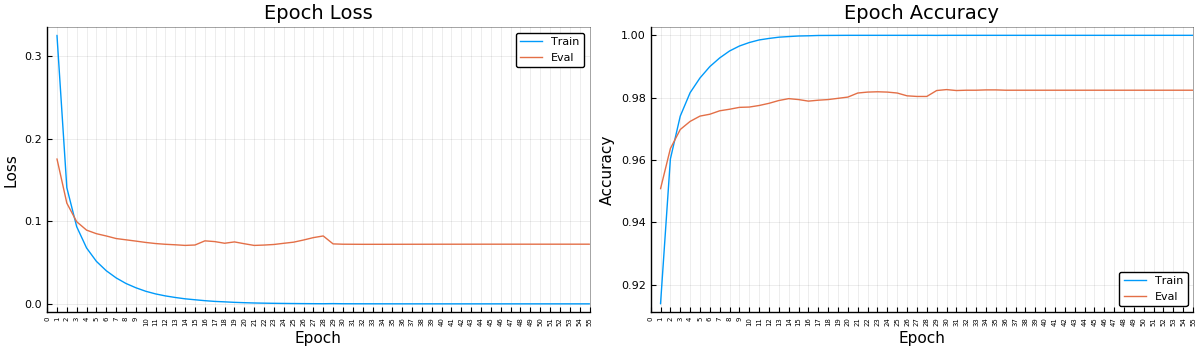

In [23]:
plot_train_log(log)

In [24]:
best_mlp = load_model("mlp_mnist.bson")
evaluate(best_mlp, dataset_test;
         metrics=[(name="Loss", fn=crossentropy), (name="Accuracy", fn=accuracy)])

Evaluation

Loss       : 0.07242845
Accuracy   : 0.9826


In [25]:
best_mlp = nothing
mlp = nothing
X1 = nothing
y1 = nothing
ŷ1 = nothing
GC.gc()

## Autoencoder

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/autoencoder.jl

In [26]:
function make_autoencoder(input_shape, hidden_size, encoded_size; use_gpu=true)
    encoder = Chain(
        flatten,
        Dense(prod(input_shape), hidden_size, leakyrelu),
        Dense(hidden_size, encoded_size, leakyrelu),
    )

    decoder = Chain(
        Dense(encoded_size, hidden_size, leakyrelu),
        Dense(hidden_size, prod(input_shape), leakyrelu),
        Reshape(input_shape),
    )

    model = Chain(encoder, decoder)

    if use_gpu
        model = gpu(model)
    end
    
    return model
end

ae_input_shape = (28, 28, 1)
ae_hidden_size = 500
ae_encoded_size = 50

autoencoder = make_autoencoder(ae_input_shape, ae_hidden_size, ae_encoded_size)

Chain(Chain(flatten, Dense(784, 500, leakyrelu), Dense(500, 50, leakyrelu)), Chain(Dense(50, 500, leakyrelu), Dense(500, 784, leakyrelu), Reshape((28, 28, 1))))

In [27]:
x1 = gpu(dataset_train[1].X)
x̂1 = autoencoder(x1)
println("x : type=$(typeof(x1)), size=$(size(x1))")
println("x̂ : type=$(typeof(x̂1)), size=$(size(x̂1))")

x : type=CuArray{Float32,4,Nothing}, size=(28, 28, 1, 256)
x̂ : type=CuArray{Float32,4,CuArray{Float32,2,Nothing}}, size=(28, 28, 1, 256)


In [28]:
autoencoder_mse(model, x) = mse(model, x, x)

loss_train = autoencoder_mse(autoencoder, x1)

println("Train (batch 1)\n")    
println("Loss     : ", loss_train)

Train (batch 1)

Loss     : 0.10624546


In [29]:
dataset2_train = [(X=X,) for (X, _) in dataset_train]
dataset2_test = (X=dataset_test.X,)

println("Train\n")
println("Number of batches   : ", length(dataset2_train))
println("First batch X shape : ", size(dataset2_train[1].X))
println("Last batch X shape  : ", size(dataset2_train[end].X))
println()
println("Test\n")
println("X shape             : ", size(dataset2_test.X))

Train

Number of batches   : 235
First batch X shape : (28, 28, 1, 256)
Last batch X shape  : (28, 28, 1, 96)

Test

X shape             : (28, 28, 1, 10000)


In [30]:
log = run_train(autoencoder, dataset2_train, dataset2_test;
                loss=autoencoder_mse,
                metric=(name="MSE", fn=autoencoder_mse),
                early_stopping_mode=:min,
                model_file="ae_mnist.bson");

[1] Eval MSE: 0.0122
 -> New best MSE! Saving model out to ae_mnist.bson
[2] Eval MSE: 0.0100
 -> New best MSE! Saving model out to ae_mnist.bson
[3] Eval MSE: 0.0090
 -> New best MSE! Saving model out to ae_mnist.bson
[4] Eval MSE: 0.0083
 -> New best MSE! Saving model out to ae_mnist.bson
[5] Eval MSE: 0.0076
 -> New best MSE! Saving model out to ae_mnist.bson
[6] Eval MSE: 0.0073
 -> New best MSE! Saving model out to ae_mnist.bson
[7] Eval MSE: 0.0070
 -> New best MSE! Saving model out to ae_mnist.bson
[8] Eval MSE: 0.0067
 -> New best MSE! Saving model out to ae_mnist.bson
[9] Eval MSE: 0.0065
 -> New best MSE! Saving model out to ae_mnist.bson
[10] Eval MSE: 0.0064
 -> New best MSE! Saving model out to ae_mnist.bson
[11] Eval MSE: 0.0062
 -> New best MSE! Saving model out to ae_mnist.bson
[12] Eval MSE: 0.0060
 -> New best MSE! Saving model out to ae_mnist.bson
[13] Eval MSE: 0.0059
 -> New best MSE! Saving model out to ae_mnist.bson
[14] Eval MSE: 0.0058
 -> New best MSE! Saving 

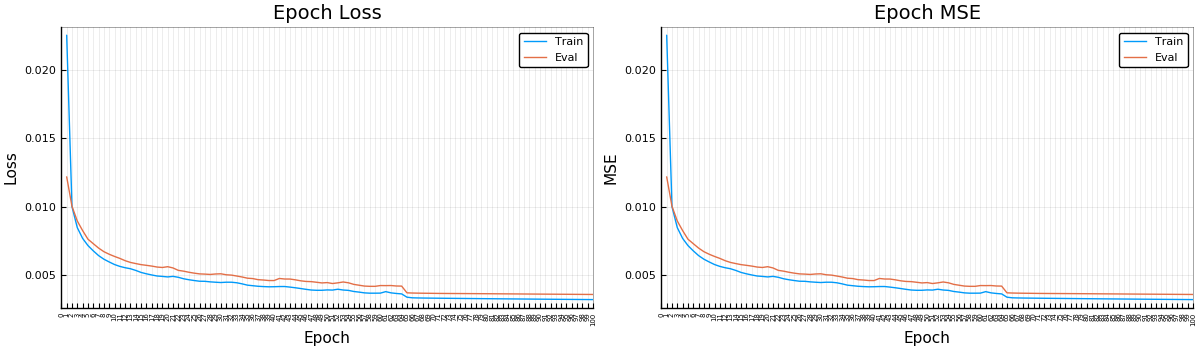

In [31]:
plot_train_log(log)

In [32]:
best_autoencoder = load_model("ae_mnist.bson")
evaluate(best_autoencoder, dataset2_test;
         metrics=[(name="Loss", fn=autoencoder_mse)])

Evaluation

Loss       : 0.0035786002


In [33]:
best_autoencoder = nothing
autoencoder = nothing
x1 = nothing
x̂1 = nothing
GC.gc()